# Generative Adversarial Network for MNIST 
author: marvin sachio

## 1. Import libraries and Data Loading
the data that used today are MNIST data where the data is about handwritten numbers and using GAN model to generate the handwritten numbers.
the data are loaded from tensorflow built-in dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization, UpSampling2D, Conv2D, ZeroPadding2D, Input
from tensorflow.keras.optimizers import Adam
import os

# Load the dataset
(x_train, _), (_, _) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize the images to [-1, 1]
x_train = np.expand_dims(x_train, axis=3)  # Add a channel dimension


2024-08-22 06:02:58.413824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 06:02:58.413919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 06:02:58.551673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 2. Creating the GAN model

In [2]:
# Generator and discriminator models
generator = models.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

discriminator = models.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### Generator Explanation
The generator model is defined using a Sequential model. It takes random noise as input and generates an image.

Dense and Reshape: Convert the noise into a low-resolution image.

Conv2DTranspose: Upsampling layers to generate a 28x28 image.

BatchNormalization and LeakyReLU: Improve model performance and stability.

tanh activation: Outputs pixel values in the range [-1, 1].

### Discriminator Explanation 
The discriminator model is defined to classify whether an image is real or fake.

Conv2D layers: Extract features from the image.

LeakyReLU and Dropout: Introduce non-linearity and reduce overfitting.

Flatten and Dense: Flatten the output and produce a single value (real or fake).


## 3. Traning the model 

GAN model consist of two models that area trained together in a competitive manner, so in this part are separated into some part

### 1. define loss function and optimizer
Loss Function (cross_entropy): The Binary Crossentropy loss is used to measure the difference between the predicted outputs and the actual labels. This loss function is crucial for both the Generator and the Discriminator. The from_logits=True argument indicates that the output of the Discriminator is not passed through a sigmoid activation function.

Optimizers: The Adam optimizer is used for both the Generator and Discriminator. The learning rate is set to 1e-4, which is a common choice for stabilizing GAN training.

### 2. prepare the dataset
BUFFER_SIZE and BATCH_SIZE: BUFFER_SIZE is used to shuffle the dataset, and BATCH_SIZE determines the number of images fed into the model at each training step.

noise_dim: This represents the dimensionality of the noise vector that will be input to the Generator. It is typically set to a relatively small value (e.g., 100).

seed: A fixed random noise input that is used to generate and save images at each epoch, allowing for consistent comparison of results over time.

train_dataset: The training dataset is prepared by shuffling the images and batching them. The tf.data.Dataset API is used to efficiently load and preprocess the data

### 3. define the model loss function
discriminator_loss: This function calculates the Discriminator's loss. The Discriminator tries to maximize the difference between real images (with labels as ones) and fake images generated by the Generator (with labels as zeros). The loss is the sum of the real loss and fake loss.

generator_loss: This function calculates the Generator's loss. The Generator tries to fool the Discriminator into classifying fake images as real, so its loss is calculated by comparing the Discriminator's output on the fake images to an array of ones.

### 4. define the training step
train_step function: This function represents a single step in the training process.

Noise Generation: A batch of random noise vectors is generated, which the Generator will use to create fake images.

Gradient Tapes: TensorFlow's GradientTape is used to record operations for automatic differentiation. Two tapes are used, one for the Generator and one for the Discriminator.

Forward Pass: The Generator creates fake images from the noise, and the Discriminator evaluates both real images from the dataset and the fake images.

Loss Calculation: The loss for both models is calculated using the previously defined loss functions.

Backpropagation: The gradients of the losses with respect to the models' trainable variables are calculated and used to update the models using the Adam optimizer.

### 5. define the training loop
train function: This function manages the overall training process, iterating over multiple epochs.

Epochs: The model is trained for a specified number of epochs. During each epoch, all batches in the dataset are processed.

Save Images: Every 10 epochs, the generate_and_save_images function is called to generate images from the fixed seed and save them for visualization.

### 6. lastly we try to generate and seve images
generate_and_save_images function: This function generates images from the Generator using the fixed noise seed.

Image Generation: The Generator creates images from the test_input noise vector.

Plotting: The images are plotted in a grid using matplotlib, and the plot is saved to a file named according to the current epoch.

### 7. train the model
The GAN is trained for 500 epochs using the train function. During training, the Generator and Discriminator continuously improve as they compete with each other.

2024-08-22 06:03:15.605386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


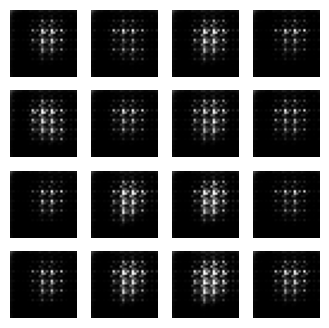

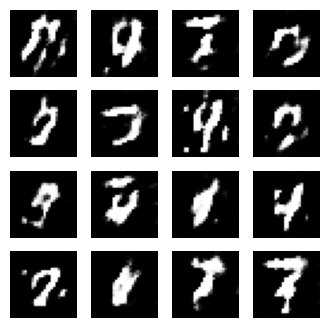

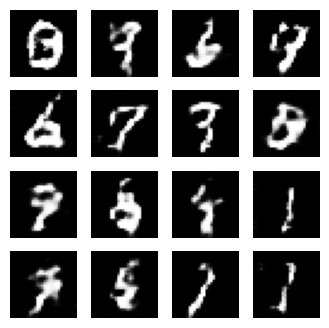

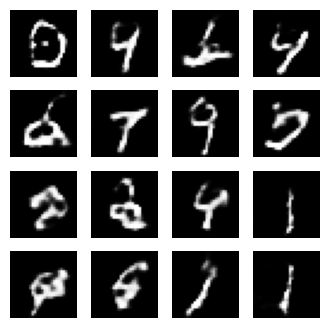

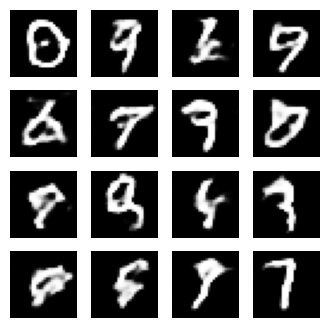

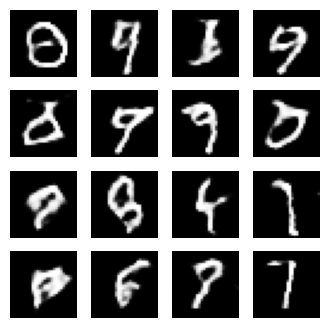

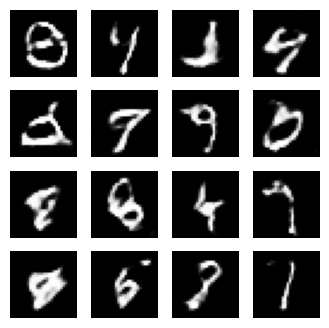

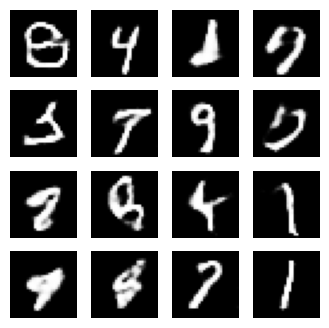

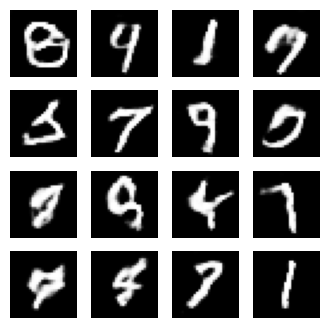

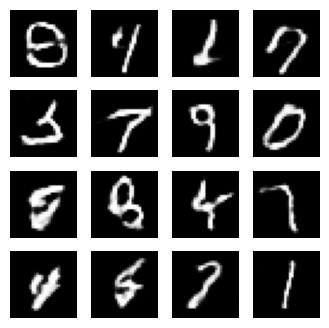

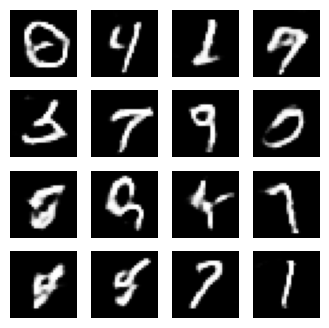

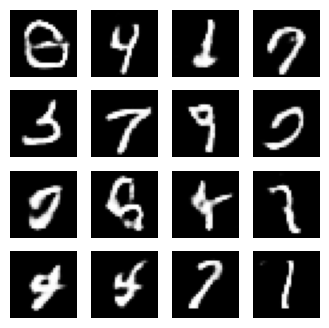

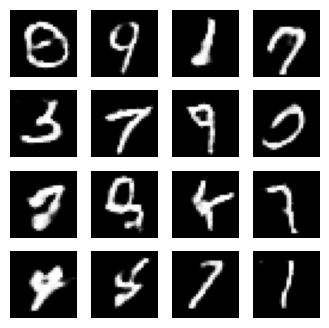

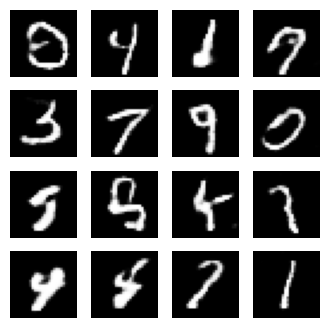

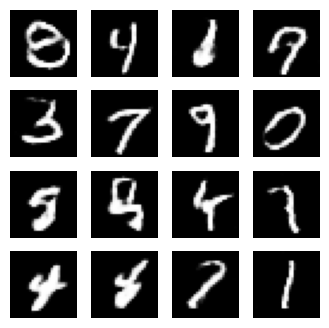

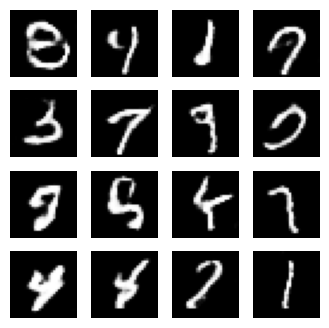

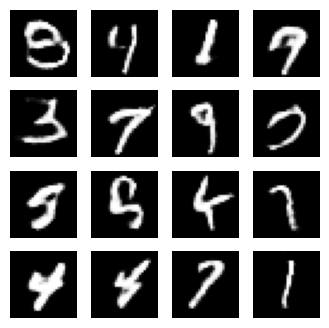

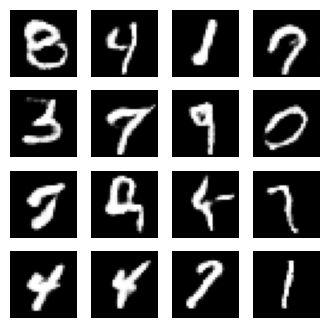

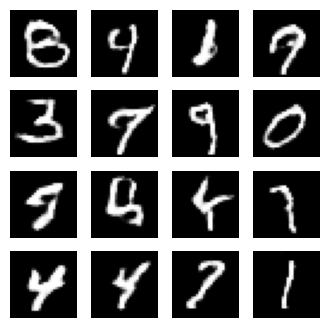

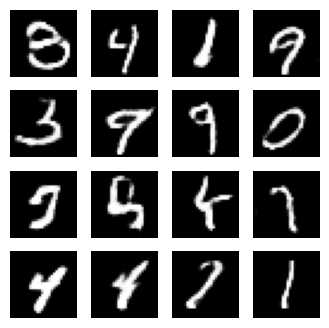

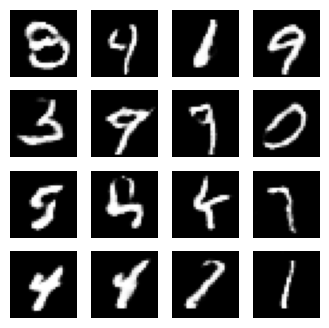

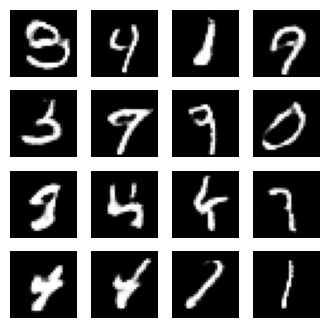

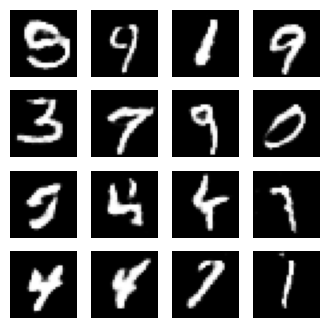

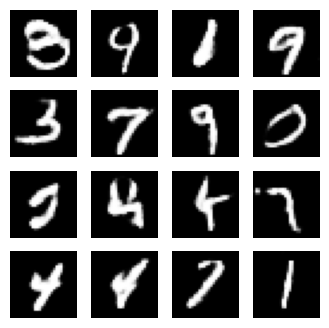

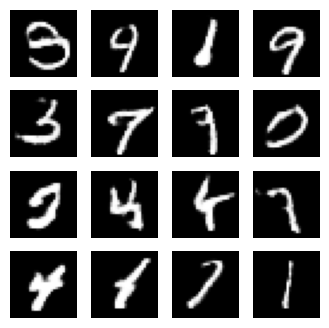

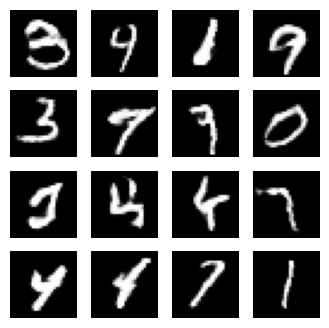

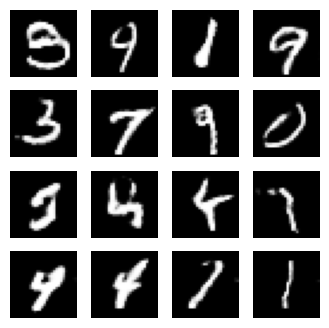

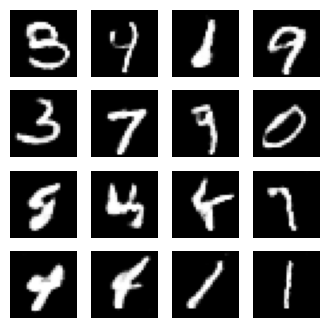

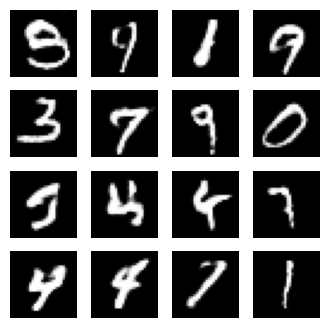

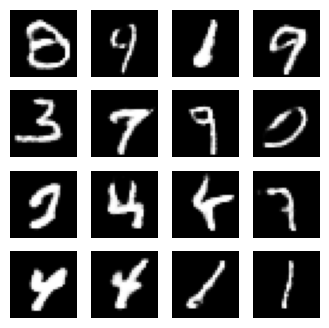

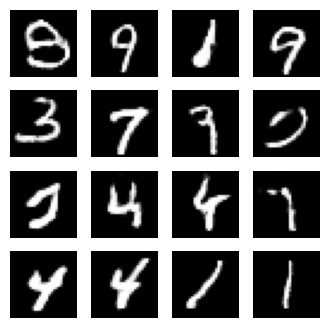

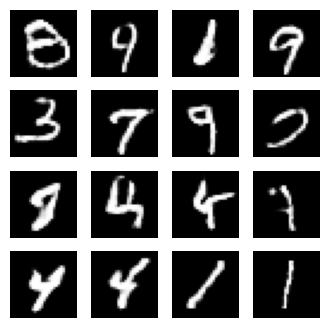

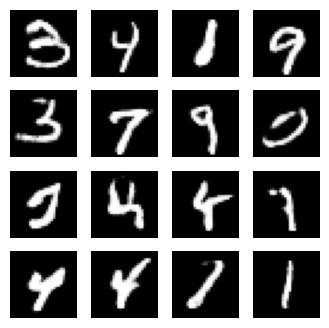

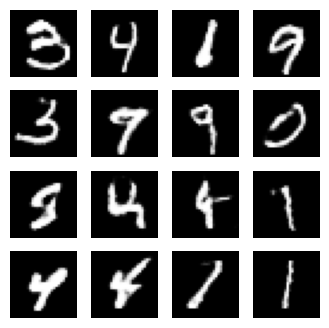

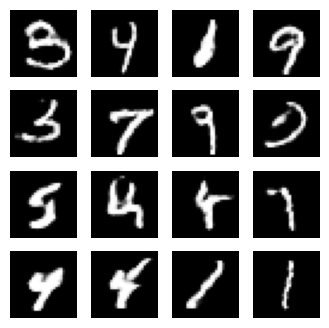

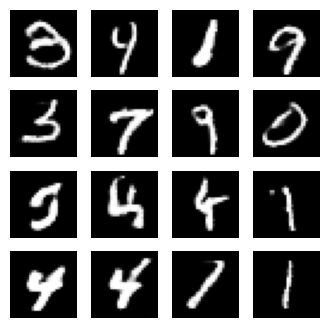

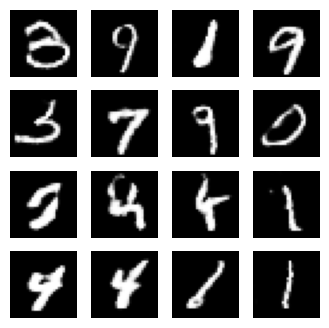

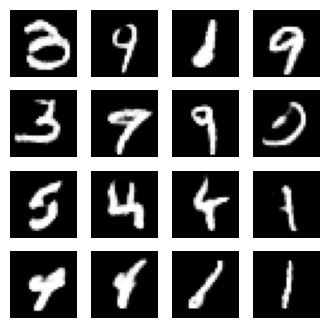

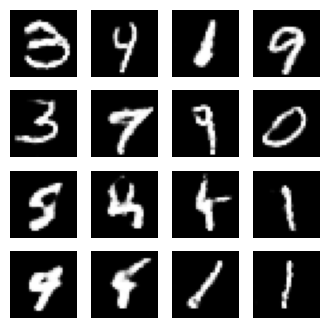

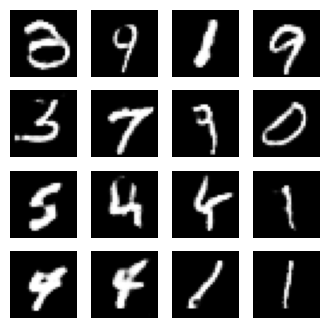

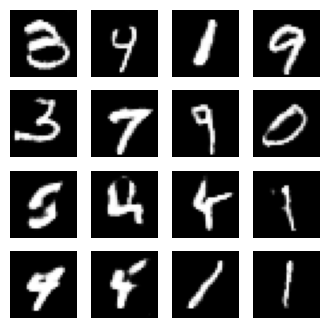

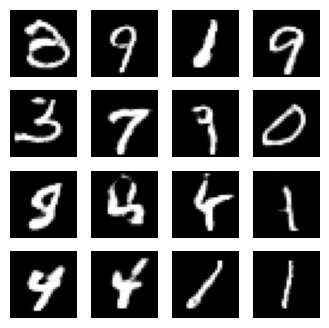

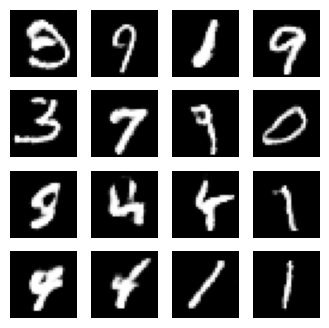

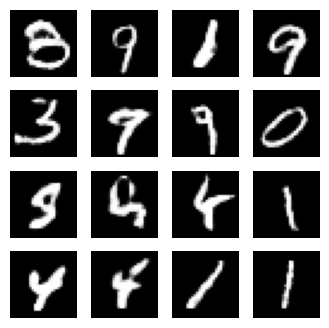

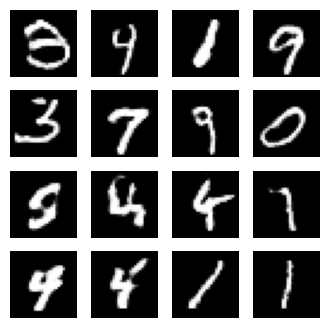

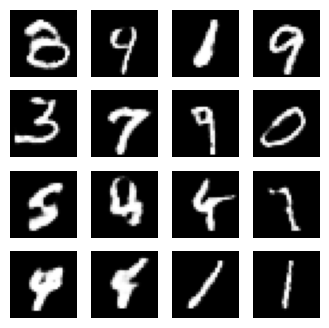

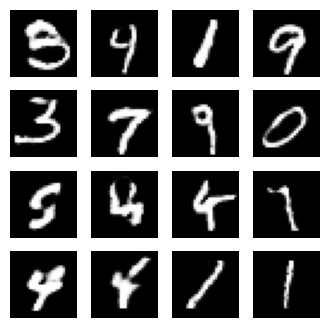

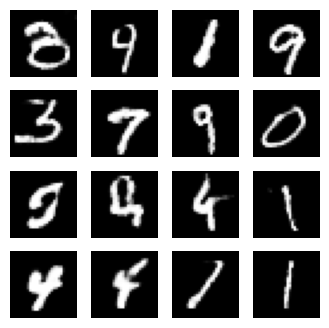

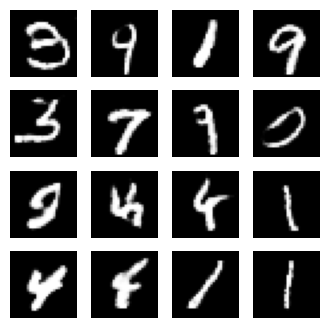

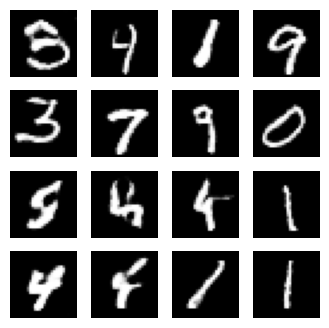

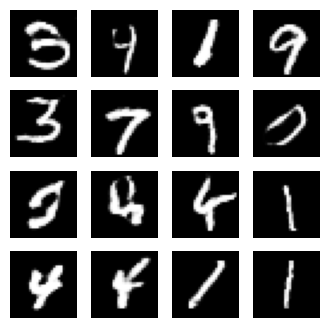

In [3]:
# Define loss function and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Prepare the dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

# Define the loss functions
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Define the training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)

# Generate and save images function
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train the GAN
EPOCHS = 500
train(train_dataset, EPOCHS)

## 4. comparing the actual with some generated images

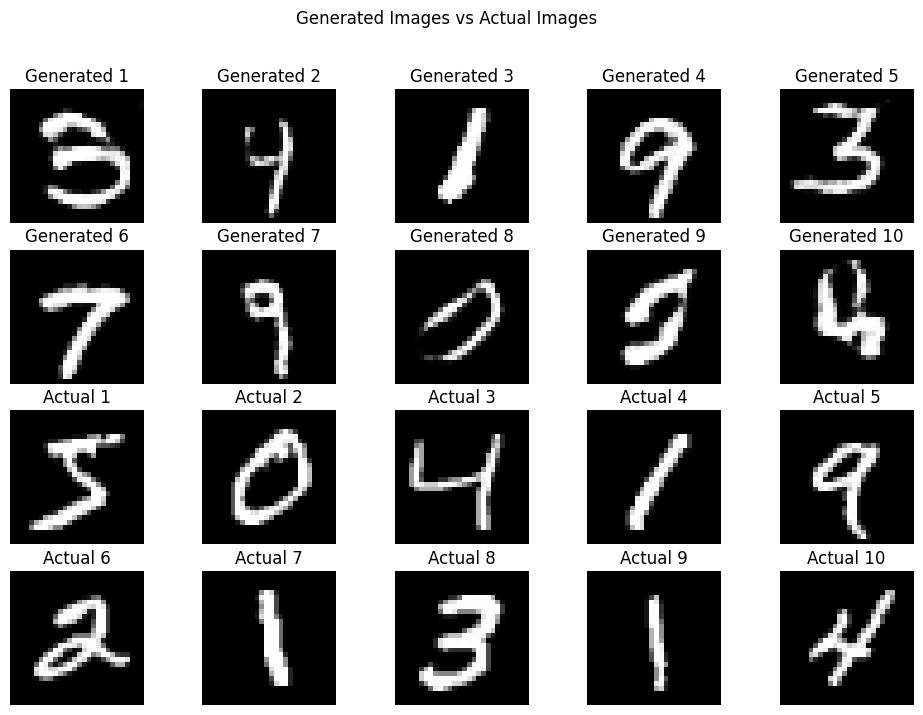

In [4]:
# Function to compare generated images with actual images
def compare_generated_with_actual(generator_model, test_input, real_images):
    predictions = generator_model(test_input, training=False)
    fig, axe = plt.subplots(4, 5, figsize=(12, 8))
    fig.suptitle('Generated Images vs Actual Images')

    idx = 0
    for i in range(2):
        for j in range(5):
            axe[i, j].imshow(predictions[idx, :, :, 0] * 127.5 + 127.5, cmap='gray')
            axe[i, j].axis('off')
            axe[i, j].set_title(f'Generated {idx+1}')
            idx += 1

    idx = 0
    for i in range(2, 4):
        for j in range(5):
            axe[i, j].imshow(real_images[idx, :, :] * 127.5 + 127.5, cmap='gray')
            axe[i, j].axis('off')
            axe[i, j].set_title(f'Actual {idx+1}')
            idx += 1

    plt.show()
    
    
# Compare generated images with actual images after training
compare_generated_with_actual(generator, seed, x_train[:10])